In [102]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from functools import reduce
from operator import mul
RANDOM_SEED=25
df = pd.read_csv('data/filmdeathcounts.csv', sep=',')

# Homework 3

In [246]:
def categorize_func(split_points):
    """Returns categorize function, can be used in apply method to dataframe"""
    def categorize(param):
        split_points.sort()
        if (param < split_points[0]):
            return '<' + str(split_points[0])
        for index in range(len(split_points) - 1):
            if param < split_points[index + 1]:
                return '≥' + str(split_points[index])
        return '≥' + str(split_points[-1])
    return categorize

def make_relative(probabilites_df):
    res = probabilites_df.copy()
    res.drop(index='Total', columns='Total', inplace=True)
    for col in res:
        for row in res[col].index:
            res[col][row] /= probabilites_df['Total'][row]
    return res

def normalize(contingency_df):
    res = contingency_df.copy()
    res = res.astype('float')
    for col in res:
        for row in res[col].index:
            res[col][row] /= contingency_df['Total']['Total']
    return res

def make_quetelet(probabilites_df):
    res = probabilites_df.copy()
    res.drop(index='Total', columns='Total', inplace=True)
    for col in res:
        for row in res[col].index:
            res[col][row] = (probabilites_df[col][row] / probabilites_df['Total'][row] - probabilites_df[col]['Total']) / \
                             probabilites_df[col]['Total']
    return res

def trunc_total(contingency_df):
    res = contingency_df.copy()
    res.drop(index='Total', columns='Total', inplace=True)
    return res

def chi_square_summary_quetelet_index(df):
    res = make_quetelet(normalize(df)) * df
    res['Total'] = res[res.columns].sum(axis=1)
    for col in res:
        res[col]['Total'] = res[col].sum()
    res = res[[col for col in res if col != 'Total'] + ['Total']]
    return res

def expected_values(contingency_df):
    res = contingency_df.copy()
    res.drop(index='Total', columns='Total', inplace=True)
    res = res.astype('float')
    for col in res:
        for row in res[col].index:
            res[col][row] = contingency_df[col]['Total'] * contingency_df['Total'][row] / contingency_df['Total']['Total']
    return res


## Making nominal features
Looking at histograms of features *IMDB_Rating*, *Year* and *Body_Count*. Make them nominal features by splitting them.

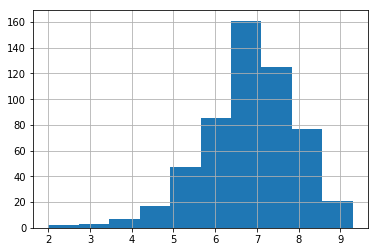

In [7]:
df['IMDB_Rating'].hist()

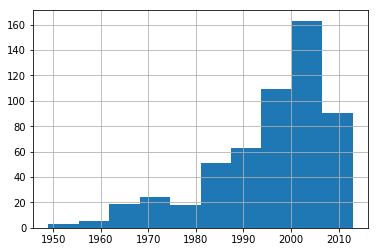

In [5]:
df['Year'].hist()

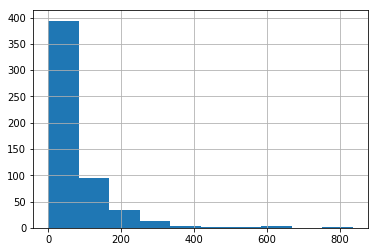

In [28]:
df['Body_Count'].hist()

## Making contingency tables

In [144]:
bodies = df['Body_Count'].apply(categorize_func([20, 50, 120]))
imdb_rating = df['IMDB_Rating'].apply(categorize_func([6.0, 7.0, 8.0]))
year = df['Year'].apply(categorize_func([1980, 1990, 2000, 2005]))

contingency_table_imdb_bodies = pd.crosstab(bodies, imdb_rating, margins=True, margins_name='Total')
contingency_table_year_bodies = pd.crosstab(bodies, year, margins=True, margins_name='Total')

Looking at contingency tables

In [145]:
contingency_table_imdb_bodies

IMDB_Rating,<6.0,≥6.0,≥7.0,≥8.0,Total
Body_Count,,,,,
<20,28,65,47,22,162
≥120,14,20,44,14,92
≥20,28,40,39,23,130
≥50,39,49,52,21,161
Total,109,174,182,80,545


In [146]:
contingency_table_year_bodies

Year,<1980,≥1980,≥1990,≥2000,≥2005,Total
Body_Count,,,,,,
<20,12,14,39,44,53,162
≥120,20,10,13,24,25,92
≥20,10,23,48,19,30,130
≥50,23,25,39,30,44,161
Total,65,72,139,117,152,545


## Relative probabilities
Finding relative probabilitiy tables

In [129]:
make_relative(normalize(contingency_table_imdb_bodies)) * 100

IMDB_Rating,<6.0,≥6.0,≥7.0,≥8.0
Body_Count,,,,
<20,17.283951,40.123457,29.012346,13.580247
≥120,15.217391,21.739130,47.826087,15.217391
≥20,21.538462,30.769231,30.000000,17.692308
≥50,24.223602,30.434783,32.298137,13.043478


We can see that film with more than 200 bodies probably will be well appreciated (will have rating more than 7.0 with ~63% chances and ~15% chances to have rating lower than 6.0)

In [125]:
make_relative(normalize(contingency_table_year_bodies)) * 100

Year,<1980,≥1980,≥1990,≥2000,≥2005
Body_Count,,,,,
<20,7.407407,8.641975,24.074074,27.160494,32.716049
≥150,15.384615,10.769231,16.923077,23.076923,33.846154
≥20,7.692308,17.692308,36.923077,14.615385,23.076923
≥50,17.553191,14.893617,21.808511,20.744681,25.000000


I don't see patterns here

## Quetelet index tables

In [148]:
make_quetelet(normalize(contingency_table_imdb_bodies)) * 100

IMDB_Rating,<6.0,≥6.0,≥7.0,≥8.0
Body_Count,,,,
<20,-13.580247,25.674046,-13.122371,-7.484568
≥120,-23.913043,-31.909045,43.215480,3.668478
≥20,7.692308,-3.625111,-10.164835,20.528846
≥50,21.118012,-4.672664,-3.283052,-11.141304


1. Films that have from 20 to 50 bodies are most probably higher than 8.0 ~21% more than average
2. Films that have 120 or more bodies are more appreciated: they have odds to have rating more than 8.0 ~4% more than average and chances that film will have rating less than 6.0 is ~43% less than average

In [150]:
make_quetelet(normalize(contingency_table_year_bodies)) * 100

Year,<1980,≥1980,≥1990,≥2000,≥2005
Body_Count,,,,,
<20,-37.891738,-34.585048,-5.608846,26.516830,17.304256
≥120,82.274247,-17.723430,-44.596497,21.516165,-2.567220
≥20,-35.502959,33.920940,44.770338,-31.919790,-17.257085
≥50,19.780220,17.537957,-5.022566,-13.202739,-2.010461


1. Films that have more than 120 bodies are most probably made before 1980 (probability is ~82% more than average)
2. Films that have less than 20 bodies are most probably made after 2000

## Chi-square

Find expected number of films in each category in assumption of independence of features. Also find number of degrees of freedom:

In [181]:
obs_values_year_bodies = trunc_total(contingency_table_year_bodies)
exp_values_year_bodies = expected_values(contingency_table_year_bodies)
degrees_of_freedom_year_bodies = reduce(mul, map(lambda x: x - 1, obs_values_year_bodies.shape), 1)
ddof_year_bodies = obs_values_year_bodies.size - degrees_of_freedom_year_bodies - 1

In [154]:
obs_values_year_bodies

Year,<1980,≥1980,≥1990,≥2000,≥2005
Body_Count,,,,,
<20,12,14,39,44,53
≥120,20,10,13,24,25
≥20,10,23,48,19,30
≥50,23,25,39,30,44


In [155]:
exp_values_year_bodies

Year,<1980,≥1980,≥1990,≥2000,≥2005
Body_Count,,,,,
<20,19.321101,21.401835,41.317431,34.777982,45.181651
≥120,10.972477,12.154128,23.464220,19.750459,25.658716
≥20,15.504587,17.174312,33.155963,27.908257,36.256881
≥50,19.201835,21.269725,41.062385,34.563303,44.902752


In [183]:
degrees_of_freedom_year_bodies

12

Count $\chi^2$

In [184]:
scipy.stats.chisquare(trunc_total(contingency_table_year_bodies), expected_values(contingency_table_year_bodies),
                      ddof=ddof_year_bodies, axis=None)

Power_divergenceResult(statistic=39.298443761187414, pvalue=9.395695391571617e-05)

We can see that critical pvalue is less than $10^{-4}$. So we can drop the hypothesis of independence with level of confidence 99.99%.

Do the same with another table:

In [174]:
obs_values_imdb_bodies = trunc_total(contingency_table_imdb_bodies)
exp_values_imdb_bodies = expected_values(contingency_table_imdb_bodies)
degrees_of_freedom_imdb_bodies = reduce(mul, map(lambda x: x - 1, obs_values_imdb_bodies.shape), 1)
ddof_imdb_bodies = obs_values_imdb_bodies.size - degrees_of_freedom_imdb_bodies - 1

In [160]:
obs_values_imdb_bodies

IMDB_Rating,<6.0,≥6.0,≥7.0,≥8.0
Body_Count,,,,
<20,28,65,47,22
≥120,14,20,44,14
≥20,28,40,39,23
≥50,39,49,52,21


In [161]:
exp_values_imdb_bodies

IMDB_Rating,<6.0,≥6.0,≥7.0,≥8.0
Body_Count,,,,
<20,32.4,51.721101,54.099083,23.779817
≥120,18.4,29.372477,30.722936,13.504587
≥20,26.0,41.504587,43.412844,19.082569
≥50,32.2,51.401835,53.765138,23.633028


In [177]:
degrees_of_freedom_imdb_bodies

9

In [185]:
scipy.stats.chisquare(trunc_total(contingency_table_imdb_bodies), expected_values(contingency_table_imdb_bodies),
                      ddof=ddof_imdb_bodies, axis=None)

Power_divergenceResult(statistic=18.231013449960972, pvalue=0.03258602359739147)

Critical pvalue here is about 3%. So we can drop the hypothesis of independence with level of confidence 95%, but we cannot drop the hypothesis with level of confidence 97%.

Now we'll compute chi-square summary Quetelet index table

In [248]:
chi_square_summary_quetelet_index(contingency_table_imdb_bodies)

IMDB_Rating,<6.0,≥6.0,≥7.0,≥8.0,Total
Body_Count,,,,,
<20,-3.802469,16.688130,-6.167515,-1.646605,5.071541
Total,3.239576,6.566671,7.175824,1.248943,18.231013
≥120,-3.347826,-6.381809,19.014811,0.513587,9.798763
≥20,2.153846,-1.450044,-3.964286,4.721635,1.461151
≥50,8.236025,-2.289605,-1.707187,-2.339674,1.899559


In [247]:
chi_square_summary_quetelet_index(contingency_table_year_bodies)

Year,<1980,≥1980,≥1990,≥2000,≥2005,Total
Body_Count,,,,,,
<20,-4.547009,-4.841907,-2.187450,11.667405,9.171256,9.262296
Total,12.906996,5.572056,11.545967,6.805703,2.467722,39.298444
≥120,16.454849,-1.772343,-5.797545,5.163880,-0.641805,13.407037
≥20,-3.550296,7.801816,21.489762,-6.064760,-5.177126,14.499397
≥50,4.549451,4.384489,-1.958801,-3.960822,-0.884603,2.129715


As we can see, total sum really equals to $\chi^2$

For table with years and number of bodies we have 12 degrees of freedom. Critical values of $\chi^2$ with 95% level of confidence is 21.02607 and with 99% level is 26.21697. Our value of $\chi^2 = 39.298444$ and we have 4360 size of dataset

In [251]:
df.size / 39.298444 * 21.02607

2332.7555971427264

In [252]:
df.size / 39.298444 * 26.21697

2908.6645059025745

We see that 2333 numbers of observations will suffice to see the features as associated at 95% confidence level and 2909 will suffice at 99% level

Table with rating and number of bodies has 9 degrees of freedom, its critical values for confidence level 95% and 99% are 16.91898 and 21.66599

In [253]:
df.size / 18.231013 * 16.91898

4046.223476446427

In [254]:
df.size / 18.231013 * 21.66599

5181.484780906031

We see that 4047 numbers of observations will suffice to see the features as associated at 95% confidence level and 5182 will suffice at 99% level